# OceanParcels small tutorial

In [63]:
import matplotlib.pyplot as plt
from parcels import Field,FieldSet, ParticleSet, ParticleFile, Variable, JITParticle, AdvectionRK4
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import timedelta
import matplotlib.ticker as mticker

## Basic example

In [64]:
# Particles starting coordinates
Lats = range(-50,-30)
Lons = np.zeros(len(Lats))*10
Densities = np.ones(len(Lats))*27.0

In [65]:
# File with the velocity data
file = 'Data/Vel_SO.nc'
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:  (gamman: 22, lat: 65, lon: 360)
Coordinates:
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -64.5 -63.5 -62.5 -61.5 -60.5 ... -3.5 -2.5 -1.5 -0.5
  * gamman   (gamman) float64 26.35 26.4 26.45 26.5 ... 27.25 27.3 27.35 27.4
Data variables:
    ugeo     (gamman, lat, lon) float64 ...
    vgeo     (gamman, lat, lon) float64 ...

In [66]:
# Define personalized kernels

def periodicBC(particle, fieldset, time):
    if particle.lon < fieldset.halo_west:
        particle_dlon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle_dlon -= fieldset.halo_east - fieldset.halo_west

Create particle set
Set up initialization


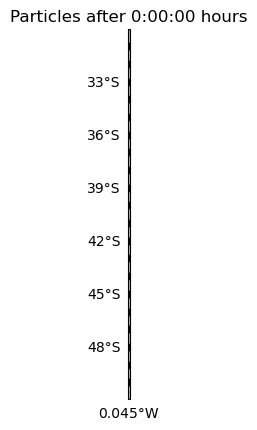

Execute run


INFO: Compiled ArrayJITParticleAdvectionRK4periodicBC ==> /tmp/parcels-1000/lib7994bd12b8fbda7ec9d1f13ab40ce7c5_0.so


In [67]:
# OceanParcels

# Setting up the fieldset 
file_names ={'U':file,
             'V':file}
variables = {'U':'ugeo',
             'V':'vgeo'}
dimensions =  {'lat':'lat',
               'lon':'lon',
               'depth':'gamman'}

print('Create particle set')
fset = FieldSet.from_netcdf(file,variables,dimensions)

# Need to add this for periodic boundaries around the globe
fset.add_constant("halo_west", fset.U.grid.lon[0])
fset.add_constant("halo_east", fset.U.grid.lon[-1])
fset.add_periodic_halo(zonal=True)

# set particleset for initialization
print('Set up initialization')

pset = ParticleSet.from_list(fieldset = fset,
                             pclass = JITParticle,
                             lat = Lats,
                             lon = Lons,
                             depth = Densities)

pset.show()

print('Execute run')

output_file = pset.ParticleFile(name = 'outputs/test_simple.zarr', outputdt=timedelta(days=30))

kernels = [AdvectionRK4, periodicBC]

pset.execute(kernels,
             runtime = timedelta(days = 365*10),
             dt = timedelta(minutes = 10),
             output_file=output_file)

### Ouputs
OceanParcels saves outputs as it runs, so even if you shut-down your computer or it freezes, it will automatically restart when you reconnect!

In [68]:
# Look at the outputs
ds = xr.open_zarr('outputs/test_simple.zarr')
ds

<xarray.Dataset>
Dimensions:     (trajectory: 20, obs: 123)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 ... 115 116 117 118 119 120 121 122
  * trajectory  (trajectory) int64 140 141 142 143 144 ... 155 156 157 158 159
Data variables:
    lat         (trajectory, obs) float32 dask.array<chunksize=(20, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 dask.array<chunksize=(20, 1), meta=np.ndarray>
    time        (trajectory, obs) timedelta64[ns] dask.array<chunksize=(20, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 dask.array<chunksize=(20, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.2

In [69]:
# Notice the format for time
ds.isel(trajectory=0).time[0:10].values

array([                0,  2592000000000000,  5184000000000000,
        7776000000000000, 10368000000000000, 12960000000000000,
       15552000000000000, 18144000000000000, 20736000000000000,
       23328000000000000], dtype='timedelta64[ns]')

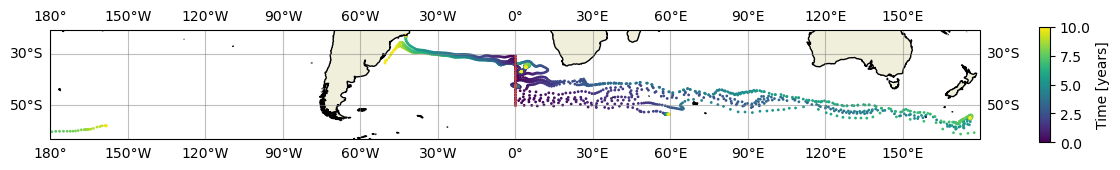

In [70]:
# Plot spaghetti

nsyr = int(3600*24*365*1e9) # nanosecondes per year

fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
l = len(ds.trajectory)
for i in range(0,l):
    dsl = ds.isel(trajectory=i)
    sc = ax.scatter( dsl.lon, dsl.lat, c=dsl.time.astype('float64')/nsyr, s=1, transform=ccrs.PlateCarree(), vmin=0, vmax=10)
ax.scatter(Lons, Lats, s=1, c='tab:red', transform=ccrs.PlateCarree(), zorder=2)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5)
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,30))
gl.ylocator = mticker.FixedLocator(np.arange(-90,90,20))
gl.xlabels_top = False
cb = plt.colorbar(sc, shrink=0.5, aspect=10)
cb.set_label('Time [years]')
plt.show()

## Adding personalized kernels

In [ ]:
# We will add two kernels:
# 1) To remove stuck particles
# 2) To keep track of the velocities along the trajectories

# First, we need to define a new particle type that includes our new variables
class ocean_particle(JITParticle):
    #add some variables
    gamman = Variable('gamman', dtype=np.float32, to_write='once', initial=0.)

    # will use these variables to check whether the particle is stuck
    lonprev = Variable('lonprev', dtype=np.float32)
    latprev = Variable('latprev', dtype=np.float32)

    # we use these variables to store the velocity
    ugeo = Variable('ugeo', dtype=np.float32)
    vgeo = Variable('vgeo', dtype=np.float32)

# 1) Kernel that removes stuck particles
def check_stuck(particle, fieldset, time):

    if (particle.lonprev == particle.lon) and (particle.latprev == particle.lat):
        particle.delete()

    particle.lonprev = particle.lon
    particle.latprev = particle.lat

# 2) Kernel that tracks velocities
def SampleU(particle, fieldset, time):

    """Custom function that samples fieldset.P at particle location"""
    (u, v) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]

    particle.ugeo = u
    particle.vgeo = v

In [72]:
# Run OceanParcels

# Setting up the fieldset 
file_names ={'U':file,
             'V':file}
variables = {'U':'ugeo',
             'V':'vgeo'}
dimensions =  {'lat':'lat',
               'lon':'lon',
               'depth':'gamman'}

print('Create particle set')
fset = FieldSet.from_netcdf(file,variables,dimensions)

# Need to add this for periodic boundaries around the globe
fset.add_constant("halo_west", fset.U.grid.lon[0])
fset.add_constant("halo_east", fset.U.grid.lon[-1])
fset.add_periodic_halo(zonal=True)

# set particleset for initialization
print('Set up initialization')

pset = ParticleSet.from_list(fieldset = fset,
                             pclass = ocean_particle,  # changed for our new particle type
                             lat = Lats,
                             lon = Lons,
                             depth = Densities)

print('Execute run')

output_file = pset.ParticleFile(name = 'outputs/test_kernels.zarr', outputdt=timedelta(days=30))

kernels = [AdvectionRK4, periodicBC, SampleU, check_stuck]

pset.execute(kernels,
             runtime = timedelta(days = 365*10),
             dt = timedelta(minutes = 10),
             output_file=output_file)

Create particle set
Set up initialization
Execute run


INFO: Compiled Arrayocean_particleAdvectionRK4periodicBCSampleUcheck_stuck ==> /tmp/parcels-1000/libe5de449a949db1cc5cae2a47c7c1a15b_0.so
INFO: Output files are stored in outputs/test_kernels.zarr.
100%|█████████████████████| 315360000.0/315360000.0 [00:00<00:00, 391627180.04it/s]


In [ ]:
# Look at the outputs
ds = xr.open_zarr('outputs/test_kernels.zarr')
ds

AttributeError: 'Dataset' object has no attribute 'ugeo'

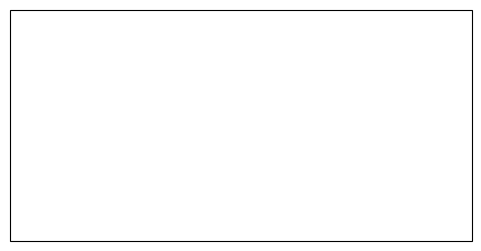

In [73]:
# Plot spaghetti

fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
l = len(ds.trajectory)
for i in range(0,l):
    dsl = ds.isel(trajectory=i)
    sc = ax.scatter( dsl.lon, dsl.lat, c=dsl.ugeo, s=1, transform=ccrs.PlateCarree(), vmin=-1e-6, vmax=1e-6, cmap='bwr')
ax.scatter(Lons, Lats, s=1, c='tab:red', transform=ccrs.PlateCarree(), zorder=2)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5)
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,30))
gl.ylocator = mticker.FixedLocator(np.arange(-90,90,20))
gl.xlabels_top = False
cb = plt.colorbar(sc, shrink=0.5, aspect=10)
cb.set_label('ugeo [m/s]')
plt.show()